# HOMER DATA PROCESSING SCRIPT
The goal of this script is to take the output file of HOMER Pro Batch Runs (.xlsx file containing one optimal case/sheet) and produce a condensed data set + plots.

General flow:
1) Run HOMER study via batch process. Select "export results" and name the file.


2) Import file to this script.


3) Use Pandas to pull .xlsx data into a more usable format. 


4) Output a trimmed .csv/HDF5 that holds the data as a dataframe


Goals:


Have this script take a large HOMER study (>100 cases) and build one easily accessible database.


Potentially couple this script with a HOMER input reading script to do cartography w/HOMER geography + results.


In [139]:
# Block of dependencies and working directory
import matplotlib.pyplot as plt
import numpy  as np 
import pandas as pd
import os 
import shutil
from pathlib import Path
from cycler import cycler

loc_directory =  os.getcwd() + '/Data' #home PC
print(loc_directory)
mlr_directory =  os.getcwd() + '/MLR_data' #home PC

util_directory = os.getcwd() +  '/util_data' #home PC
#directory = 'c:/repo/homer/ClimateStudies/OutputProcessing/Data' #laptop

trim_directory = os.getcwd() + '/TrimmedData'
print(trim_directory)

coord_loc = '/home/rdailey/repos/homer/ClimateStudies/docsandreports/uRXClimateStudiesMasterFile.xlsx'
coords_xls = pd.ExcelFile(coord_loc)
for sheet in coords_xls.sheet_names:
    coords_df = coords_xls.parse(sheet)
display(coords_df)

image_dir = os.getcwd() + '/output_graphs'
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/rdailey/repos/homer/ClimateStudies/OutputProcessing/Data
/home/rdailey/repos/homer/ClimateStudies/OutputProcessing/TrimmedData


,KCC,Name/Nearby Landmark,Latitude (decimal degrees),Neg. Latitude (decimal degrees),Longitude (decimal degrees),Neg. Longitude,DATA IMPORTED? (Y/N),Reference:
0,Dfc,"Anchorage, AK",61.21833,-61.21833,149.90000,-149.90000,Y,NaN
1,Dfb,"Ashland, WI",46.59333,-46.59333,90.84000,-90.84000,Y,NaN
2,Cfa,"Atlanta, GA",33.74833,-33.74833,84.38833,-84.38833,Y,NaN
3,Dfb,"Bangor, ME",44.80167,-44.80167,68.77167,-68.77167,Y,NaN
4,Bsk,"Bend, OR",44.06000,-44.06000,121.24670,-121.24670,Y,NaN
...,...,...,...,...,...,...,...,...
57,Csa,"Sacramento, CA",38.58167,-38.58167,121.49500,-121.49500,Y,NaN
58,Dfa,"South Bend, IN",41.67667,-41.67667,86.25167,-86.25167,Y,NaN
59,Dfb,"Syracuse, NY",43.04833,-43.04833,76.14667,-76.14667,Y,NaN
60,Dfa,"Wadena, MN",46.44167,-46.44167,95.13667,-95.13667,Y,NaN


## Following this guide for xlsx reading
https://stackoverflow.com/questions/26521266/using-pandas-to-pd-read-excel-for-multiple-worksheets-of-the-same-workbook

In [140]:
# reads, maps all sheets for locational variance studies
files = os.listdir(loc_directory)
output_df = {} #creates empty dictionary
names = [] #creates empty list for future name storage
for file in files:
    if file.endswith('.xlsx'):
        xls = pd.ExcelFile(loc_directory + '/' + file) #reads file
        names = names + xls.sheet_names
        for sheet_name in xls.sheet_names: #pulls individual sheets
            output_df[sheet_name] = xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
display(output_df[sheet_name])

,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),System/Total Fuel\n(L/yr),...,GenLarge/Fuel Cost\n($/yr),PV/Capital Cost\n($),PV/Production\n(kWh/yr),G1500/Capital Cost\n($),G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh)
0,9717.203600,7,3000,19318,146304176,0.120247,1774010.500,84637992,82.697044,1563982.500,...,0,7287902.50,18121926.0,10762500,37085996,267750,3.863608,3361338.25,19318.039062,15454.430664
1,9626.916355,7,3000,20055,147095840,0.120894,1791503.125,84821600,82.707527,1563088.375,...,0,7220187.50,17953546.0,10762500,37085996,267750,4.011008,3380700.75,20055.041016,16044.032227
2,12342.332860,6,3000,19997,147284448,0.121052,1783141.000,85300880,82.047417,1622996.375,...,0,9256750.00,23017614.0,9225000,31787996,229500,3.999408,3405818.25,19997.039062,15997.631836
3,9707.853087,7,3000,20334,147485664,0.121211,1798234.250,84977440,82.784897,1556145.250,...,0,7280890.00,18104488.0,10762500,37085996,267750,4.066808,3386342.00,20334.041016,16267.232422
4,13972.567383,5,3000,20721,147681712,0.121381,1796524.000,85232944,80.746681,1740652.000,...,0,10479426.00,26057892.0,7687500,26489996,191250,4.144208,3524808.25,20721.041016,16576.833984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10735.413042,3,4000,7268,160968720,0.132282,1893683.500,95142600,66.130295,3064937.250,...,0,8051560.00,20020818.0,4612500,15893998,114750,1.453603,3412067.50,7268.014648,5814.411621
1996,5289.826586,4,4000,10556,160970480,0.132295,1934742.500,93717120,66.466148,3033207.500,...,0,3967370.00,9865168.0,6150000,21191998,153000,2.111204,4077359.00,10556.021484,8444.816406
1997,9101.653320,4,4000,12595,160970944,0.132225,1832509.375,97271288,71.572815,2572809.000,...,0,6826240.00,16973966.0,6150000,21191998,153000,2.519005,3970566.00,12595.025391,10076.020508
1998,5506.897522,4,4000,11635,160972208,0.132285,1919523.625,94247864,67.322884,2955959.000,...,0,4130173.25,10269991.0,6150000,21191998,153000,2.327005,4129672.00,11635.023438,9308.018555


In [141]:
# reads, maps all sheets for MLR variance studies
mlr_files = os.listdir(mlr_directory)
mlr_output_df = {} #creates empty dictionary
mlr_names = [] #creates empty list for future name storage
for file in mlr_files:
    if file.endswith('.xlsx'):
        mlr_xls = pd.ExcelFile(mlr_directory + '/' + file) #reads file
        mlr_names = mlr_names + mlr_xls.sheet_names
        for sheet_name in mlr_xls.sheet_names: #pulls individual sheets
            mlr_output_df[sheet_name] = mlr_xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
display(mlr_output_df[sheet_name])

,Architecture/PV\n(kW),Architecture/G1500,Architecture/GenLarge\n(kW),Architecture/1kWh LI,Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),System/Total Fuel\n(L/yr),...,GenLarge/Fuel Cost\n($/yr),PV/Capital Cost\n($),PV/Production\n(kWh/yr),G1500/Capital Cost\n($),G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh)
0,8400.087500,NaN,5000,1500.0,78370784,0.064357,9.078901e+05,46811720,26.248690,6703879.5,...,0,6300065.5,19455522.0,NaN,NaN,NaN,0.300001,301970.437500,1500.003052,1200.002441
1,8100.084375,NaN,5000,1500.0,78408192,0.064389,9.154390e+05,46586720,25.203970,6798717.0,...,0,6075063.5,18760682.0,NaN,NaN,NaN,0.300001,313344.562500,1500.003052,1200.002441
2,8518.400533,NaN,5000,1463.0,78416336,0.064394,9.070109e+05,46887840,26.430204,6687436.0,...,0,6388800.5,19729548.0,NaN,NaN,NaN,0.292601,283585.406250,1463.002930,1170.402344
3,8000.083333,NaN,5000,1250.0,78423584,0.064406,9.204919e+05,46426468,24.016087,6906249.5,...,0,6000062.5,18529068.0,NaN,NaN,NaN,0.250001,243308.093750,1250.002441,1000.002014
4,8171.175784,NaN,5000,1554.0,78423592,0.064400,9.138184e+05,46658452,25.682077,6755447.5,...,0,6128382.0,18925338.0,NaN,NaN,NaN,0.310801,333990.656250,1554.003052,1243.202515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9749.981785,1.0,7000,495.0,108639968,0.089194,1.254888e+06,65018936,0.000000,9202906.0,...,0,7312486.5,22582024.0,1537500.0,1931949.625,38250.0,0.099000,28295.386719,495.000977,396.000793
1996,14400.150000,NaN,6000,12000.0,108645512,0.089198,1.316228e+06,62892268,23.172131,6987338.5,...,0,10800112.0,33352324.0,NaN,NaN,NaN,2.400005,359803.875000,12000.024414,9600.019531
1997,24000.250000,3.0,5000,NaN,108664280,0.089241,1.324806e+06,62612844,37.810287,5653240.5,...,0,18000188.0,55587204.0,4612500.0,5795848.500,114750.0,NaN,NaN,NaN,NaN
1998,NaN,5.0,5000,8526.0,108671344,0.089287,1.670738e+06,50595020,2.738913,8833800.0,...,0,NaN,NaN,7687500.0,9659748.000,191250.0,1.705203,668805.562500,8526.016602,6820.813477


In [142]:
# Populating list of proper utility sheet names
os.chdir('/home/rdailey/repos/homer/ClimateStudies/ProductionCases/UtilityConnection')
homer_util_dirs = os.path.abspath(os.getcwd()) 
print(homer_util_dirs)
fixed_util_names = []
for path, subdirs, files in os.walk(homer_util_dirs):
    for name in files:
        if name[-6:] == '.homer':
            #print(name.replace('.homer',''))
            fixed_util_names.append(name.replace('.homer',""))
print(len(fixed_util_names))
os.chdir('/home/rdailey/repos/homer/ClimateStudies/OutputProcessing')

/home/rdailey/repos/homer/ClimateStudies/ProductionCases/UtilityConnection
620


In [143]:
# reads, maps all sheets for utility variance studies
util_files = os.listdir(util_directory)
print(os.listdir)
util_output_df = {} #creates empty dictionary
util_names = [] #creates empty list for future name storage

for file in util_files:
    if file.endswith('.xlsx'):
        util_xls = pd.ExcelFile(util_directory + '/' + file) #reads file
        #print(util_xls.sheet_names)
        util_names = util_names + util_xls.sheet_names

        
        #util_opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
        #                                                 'Cost/COE\n($)','GenMin'])
        #util_new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
        n_util = len(util_names)
                    

        
                
        # for i in fixed_util_names:
        #     #print(i)
        #     index = fixed_util_names.index(i)
        #     match = [match for match in fixed_util_names if i in match]
        #     fixed_util_names[index] = match
            
        #print(fixed_util_names)
        for i in fixed_util_names:
            index = fixed_util_names.index(i)
            match = [match for match in fixed_util_names if i in match]
            fixed_util_names[index] = ''.join(match)
            for sheet_name in util_xls.sheet_names: #pulls individual sheets
                if sheet_name in fixed_util_names[index]:
                    util_output_df[fixed_util_names[index]] = util_xls.parse(sheet_name) #puts each sheet into a dictionary w/key "sheet_name"
                    #print('corrected', sheet_name, ' to ', fixed_util_names[index])
display(util_output_df[fixed_util_names[index]])

<built-in function listdir>


,Architecture/PV\n(kW),Architecture/G1500,Architecture/1kWh LI,Architecture/Grid\n(kW),Architecture/Converter\n(kW),Cost/NPC\n($),Cost/COE\n($),Cost/Operating cost\n($/yr),Cost/Initial capital\n($),System/Ren Frac\n(%),...,G1500/Production\n(kWh/yr),G1500/O&M Cost\n($),1kWh LI/Autonomy\n(hr),1kWh LI/Annual Throughput\n(kWh/yr),1kWh LI/Nominal Capacity\n(kWh),1kWh LI/Usable Nominal Capacity\n(kWh),Converter/Rectifier Mean Output\n(kW),Converter/Inverter Mean Output\n(kW),Grid/Energy Purchased\n(kWh),Grid/Energy Sold\n(kWh)
0,17854.413316,4,33801,2600,10304.000196,128493608,0.105610,2802470.50,31077254,72.274178,...,13626349.0,153000,6.760213,2965067.25,33801.066406,27040.853516,358.808533,305.052979,9704472,-7.844392e-12
1,18350.846615,4,33276,2600,23902.855820,128506984,0.105620,2796903.00,31284154,72.325722,...,13626349.0,153000,6.655213,2962585.50,33276.066406,26620.853516,358.478333,304.797668,9686437,-4.892087e-12
2,18325.647439,4,33308,2600,19154.371607,128508992,0.105622,2797327.25,31271418,72.323181,...,13626349.0,153000,6.661613,2962753.75,33308.066406,26646.453125,358.500519,304.815002,9687340,-5.741185e-12
3,17965.382978,4,33704,2600,8378.943848,128517256,0.105628,2801763.25,31125480,72.286026,...,13626349.0,153000,6.740813,2964736.50,33704.066406,26963.253906,358.762909,305.018982,9700384,-2.756906e-12
4,18673.050350,4,32952,2600,12253.661050,128518072,0.105629,2793783.75,31403674,72.358116,...,13626349.0,153000,6.590413,2961146.25,32952.066406,26361.652344,358.285645,304.649597,9675119,-7.005951e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,19458.065225,3,35165,2600,16466.177561,130428328,0.107170,2854200.75,31213780,70.639915,...,10219762.0,114750,7.033014,3222066.50,35165.070312,28132.056641,389.798676,331.493683,10279336,-9.952039e-12
1996,20146.093731,3,34425,2600,25771.367848,130428640,0.107174,2846356.50,31486766,70.705399,...,10219762.0,114750,6.885014,3217583.00,34425.070312,27540.054688,389.214661,331.032410,10256029,-3.726797e-12
1997,20462.141598,3,34088,2600,24825.307883,130428912,0.107177,2842878.50,31607940,70.734062,...,10219762.0,114750,6.817614,3215346.50,34088.066406,27270.455078,388.925293,330.802338,10245717,-1.037748e-11
1998,21369.685409,3,33126,2600,8254.217469,130429040,0.107187,2833214.75,31943984,70.811996,...,10219762.0,114750,6.625213,3208737.00,33126.066406,26500.853516,388.072052,330.122314,10217529,-4.181544e-12


In [144]:
#pulling interesting data points from each LOC VAR Case
opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)','GenMin'])
new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
tencases = ['Case10','Case11', 'Case12', 'Case13','Case14','Case15','Case16']
n = len(names)
display(n)
for i in range(n):
    name = names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[5:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-2]
                case_num = name[:5]
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-2]
                case_num = name[:5]
    else: 
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
            #elif name[:6] == 'Case10' or name[:6]=='Case':
            elif name[:6] in tencases:
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
            else:
                Location = name[5:-3]
                case_num = name[:5]
    if "AZYuma".casefold() in Location.casefold():
        print(Location)
        Location = Location.replace("AZYuma","YumaAZ")
        print(Location)
    KCC = KCC.lower()
    filtered_out = output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)']) #Filtering objects of interest
    filtered_out['CaseName'] = Location #adding actual case name to series
    filtered_out['CaseNum'] = case_num # adding case num to series
    filtered_out['KCC'] = KCC
    framed = filtered_out.iloc[[0]] #making the actual df
    framed.set_index(['CaseNum','CaseName'], inplace=True, drop=True) #building df w/ casename and num
    opt_out = pd.concat([framed,opt_out]) #concating all DFs together
  

    
# Data Cleanup    
opt_out = opt_out[ ['KCC'] + [ col for col in opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
opt_out = opt_out.sort_index()
opt_out.to_excel(trim_directory +'/'+ "LocationalVarianceTrimmed.xlsx")


display(opt_out)
#display(new_cases)  

639

AZYuma
YumaAZ
AZYuma
YumaAZ
AZYuma
YumaAZ
AZYuma
YumaAZ
AZYuma
YumaAZ


KCC  Architecture/PV\n(kW)  Architecture/G1500  \
CaseNum CaseName                                                     
Case1   Anchorage   dfc           67432.441304                28.0   
        Ashland     dfb           39799.095877                19.0   
        AtlantaGA   cfa           92802.980815                 3.0   
        BangorME    dfb           62211.324125                20.0   
        BendOre     bsk           40050.377085                23.0   
...                 ...                    ...                 ...   
Case8   RaleighNC   cfa           32126.631249                 7.0   
        ReddingCA   csa           26843.735929                 4.0   
        RichmondVA  cfa           37944.276532                 5.0   
        Sacramento  csa           19589.237011                 2.0   
        Syracuse    dfb           74305.687555                13.0   

                   Architecture/GenLarge\n(kW) Architecture/1kWh LI  \
CaseNum CaseName                                                      
Case1   Anchorage                          NaN               238148   
        Ashland                            NaN                83635   
        AtlantaGA                          NaN               121958   
        BangorME                           NaN               143357   
        BendOre                            NaN                93120   
...                                        ...                  ...   
Case8   RaleighNC                       3000.0                40384   
        ReddingCA                         3000                38229   
        RichmondVA                        3000                46024   
        Sacramento                      3000.0                32783   
        Syracuse                           NaN                77203   

                    Cost/COE\n($) GenMin  
CaseNum CaseName                          
Case1   Anchorage        0.437239    NaN  
        Ashland          0.207991    NaN  
        AtlantaGA        0.252627    NaN  
        BangorME         0.301640    NaN  
        BendOre          0.233319    NaN  
...                           ...    ...  
Case8   RaleighNC        0.236074    NaN  
        ReddingCA        0.233377    NaN  
        RichmondVA       0.244868    NaN  
        Sacramento       0.216778    NaN  
        Syracuse         0.220980    NaN  

[639 rows x 7 columns]

In [145]:
#pulling interesting data points from each MLR  Case
mlr_opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI',
                                                 'Cost/COE\n($)'])
mlr_new_cases = pd.DataFrame(columns=['FileName','CaseNum','Case1 LCOE','Case5 LCOE','Architecture/GenLarge\n(kW)'])
tencases = ['Case10','Case11', 'Case12', 'Case13','Case14','Case15','Case16']
n_mlr = len(mlr_names)
for i in range(n_mlr):
    name = mlr_names[i] # Grabs Sheet Name
    KCC = name[-3:]     #grabs KCC from last 3 values
    if KCC[-2:].casefold() == ('Af'.casefold()):
            KCC = 'Af'
            Location = name[5:-2]
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            else:
                Location = name[5:-2]
                case_num = name[:5]
                mlr      = name[8:10]
    elif KCC[-2:].casefold() == 'Am'.casefold():
            KCC = 'Am'
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            elif name[:6] == 'Case10':
                Location = name[6:-2]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            else:
                Location = name[5:-2]
                case_num = name[:5]
                mlr      = name[8:10]
    else: 
            if name[:6] == 'Case25' or name[:6] == 'Case35':
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            #elif name[:6] == 'Case10' or name[:6]=='Case':
            elif name[:6] in tencases:
                Location = name[6:-3]
                case_num = name[:6] # Grabs Case Number 
                mlr      = name[8:10]
            else:
                Location = name[10:-3]
                case_num = name[:5]
                mlr      = name[8:10]
                #print(mlr)
    if "AZYuma".casefold() in Location.casefold():
        print(Location)
        Location = Location.replace("AZYuma","YumaAZ")
        print(Location)
    KCC = KCC.lower()
    # print(name)
    mlr_filtered_out = mlr_output_df[name].filter(['Architecture/PV\n(kW)', 'Architecture/G1500', 'Architecture/GenLarge\n(kW)', 'Architecture/1kWh LI', 'Cost/COE\n($)']) #Filtering objects of interest
    mlr_filtered_out['CaseName'] = Location #adding actual case name to series
    mlr_filtered_out['CaseNum'] = case_num # adding case num to series
    mlr_filtered_out['KCC'] = KCC
    mlr_filtered_out['mlr'] = mlr
    mlr_framed = mlr_filtered_out.iloc[[0]] #making the actual df
    mlr_framed.set_index(['CaseNum','CaseName','mlr'], inplace=True, drop=True) #building df w/ casename and num
    mlr_opt_out = pd.concat([mlr_framed,mlr_opt_out]) #concating all DFs together
  
kcc_data = mlr_opt_out.loc['Case2']['KCC']
koppens_modeled=[]
i=0
for h in range(len(kcc_data)):
    #display(kcc_data[h])
    if str(kcc_data[h]) not in koppens_modeled:
        koppens_modeled.append(kcc_data[h])
        i = i+1
    else:
        pass
display(koppens_modeled)  
# Data Cleanup    
mlr_opt_out = mlr_opt_out[ ['KCC'] + [ col for col in mlr_opt_out.columns if col != 'KCC' ] ] #sorting df to have KCC first
mlr_opt_out = mlr_opt_out.sort_index()
mlr_opt_out.to_csv(trim_directory +'/'+ "MLRTrimmed.csv")


display(mlr_opt_out)
#display(new_cases)  

AZYuma
YumaAZ
AZYuma
YumaAZ


TypeError: 'int' object is not callable

In [ ]:
#pulling interesting data points from each util  Case    
#os.chdir('OutputProcessing')
test_str = 'Grid/Energy Purchased\n(kWh)'
util_opt_out = pd.DataFrame(columns=['Architecture/PV\n(kW)', 'Architecture/G1500',
                                     test_str,'Architecture/1kWh LI','Cost/COE\n($)'])
for i in range(n_util):
    name = fixed_util_names[i] # Grabs Sheet Name
    name = ''.join(name)
    if "6cents".casefold() in name.casefold():
        case_info = name[:21]
        price = name[15:16]
        if 'Utility2dot6MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility2dot6MWe' # used for string cleanup later
            util = '2.6MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        elif'Utility1dot3MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility1dot3MWe' # used for string cleanup later
            util = '1.3MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        else:
            print('error')
        KCC = name[-3:]     #grabs KCC from last 3 values
        #print(KCC)
        if KCC[-2:].casefold() == ('Af'.casefold()) or (KCC[-2:].casefold() == 'Am'.casefold()):
                if KCC[-2:].casefold() == 'Af'.casefold():
                    KCC = 'Af'
                else: 
                    KCC = 'Am'
                Location = name[:-2]
                Location = Location.replace(KCC, "")
                Location = Location.replace(utility_str, "")
                Location = Location.replace(str(price), "")
                Location = Location.replace("Cents", "")
                case_num = name[:5]
               #else:
               #    Location = name[5:-2]
               #    case_num = name[:5]
        else: 
                Location = Location.replace(KCC, "")
                Location = Location.replace(str(price), "")
    else:     
        case_info = name[:22]
        price = name[15:17]
        if 'Utility2dot6MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility2dot6MWe' # used for string cleanup later
            util = '2.6MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        elif'Utility1dot3MWe'.casefold() in case_info.casefold() :
            utility_str = 'Utility1dot3MWe' # used for string cleanup later
            util = '1.3MWe'
            Location = name.replace(utility_str, "")
            Location = Location.replace("Cents", "")
        else:
            print('error')
        KCC = name[-3:]     #grabs KCC from last 3 values
        #print(KCC)
        if KCC[-2:].casefold() == ('Af'.casefold()) or (KCC[-2:].casefold() == 'Am'.casefold()):
                if KCC[-2:].casefold() == 'Af'.casefold():
                    KCC = 'Af'
                else: 
                    KCC = 'Am'
                Location = name[:-2]
                Location = Location.replace(KCC, "")
                Location = Location.replace(utility_str, "")
                Location = Location.replace(str(price), "")
                Location = Location.replace("Cents", "")
                case_num = name[:5]
               #else:
               #    Location = name[5:-2]
               #    case_num = name[:5]
        else: 
                Location = Location.replace(KCC, "")
                Location = Location.replace(str(price), "")
        #print(utility_str)

    KCC = KCC.lower()
    #print(name)
    util_filtered_out = util_output_df[name].filter(['Architecture/PV\n(kW)',test_str, 'Architecture/G1500', 'Architecture/1kWh LI', 'Cost/COE\n($)']) #Filtering objects of interest
    #print(Location)
    util_filtered_out['CaseName'] = Location #adding actual case name to series
    util_filtered_out['CaseNum'] = util # adding case num to series
    util_filtered_out['Price'] = price # adding case num to series
    util_filtered_out['KCC'] = KCC
    #util_filtered_out['util'] = util add back to .set_index line
    util_framed = util_filtered_out.iloc[[0]] #making the actual df
    util_framed.set_index(['CaseNum','Price','CaseName','KCC'], inplace=True, drop=True) #building df w/ casename and num
    util_opt_out = pd.concat([util_framed,util_opt_out]) #concating all DFs together
  

    
# Data Cleanup    
#util_opt_out = util_opt_out[ ['GenMin'] + [ col for col in util_opt_out.columns if col != 'GenMin ' ] ] #sorting df to have KCC first
util_opt_out = util_opt_out.sort_index()
util_opt_out.to_csv(trim_directory +'/'+"utilTrimmed.csv")


display(util_opt_out)


In [ ]:
# DATA FOR LOC VAR
#for index = opt_out.ind 
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
CFA = opt_out.query("KCC=='cfa'")
#print(CFA.query("CaseNum=='Case1'"))
#CFA.plot(x='CaseName',y='Cost/COE\n($)')
Case1 = opt_out.loc[("Case1",slice(None))]
Case1CFA = Case1.query("KCC=='cfa'")
Case2 = opt_out.loc[("Case2",slice(None))]
Case2CFA = Case2.query("KCC=='cfa'")
Case25 = opt_out.loc[("Case25",slice(None))]
Case3 = opt_out.loc[("Case3",slice(None))]
Case3CFA = Case3.query("KCC=='cfa'")
Case35 = opt_out.loc[("Case35",slice(None))]
Case4 = opt_out.loc[("Case4",slice(None))]
Case4CFA = Case4.query("KCC=='cfa'")
display(Case4)
# Testing
Case5 = opt_out.loc[("Case5",slice(None))]
Case6 = opt_out.loc[("Case6",slice(None))]
Case7 = opt_out.loc[("Case7",slice(None))]
Case8 = opt_out.loc[("Case8",slice(None))]
Case10 = opt_out.loc[("Case10",slice(None))]
Case11 = opt_out.loc[("Case11",slice(None))]
Case12 = opt_out.loc[("Case12",slice(None))]
Case13 = opt_out.loc[("Case13",slice(None))]
Case14 = opt_out.loc[("Case14",slice(None))]
Case15 = opt_out.loc[("Case15",slice(None))]
Case16 = opt_out.loc[("Case16",slice(None))]
#display(Case16)
Case1CFA.plot(y='Cost/COE\n($)', use_index=True)

plt.xticks(rotation=90);
plt.savefig(image_dir + '/loc_var.svg')

"KCC=='dfa'"

"KCC=='dfb'"

"KCC=='dfc'"

['BurlingtonVT', 'Chicago', 'ColumbusOH', 'DesMoinesIA', 'DetroitMI', 'LancasterPA', 'LincolnNE', 'SouthBendIN', 'WadenaMN', 'Ashland', 'BangorME', 'BismarckND', 'BrewsterMA', 'CoalvilleUT', 'IdahoFalls', 'LosAlamosNM', 'Syracuse', 'UPMich', 'Anchorage', 'CrestedButteCO', 'EielsonAFB']
{'BurlingtonVT': 'black', 'Chicago': 'red', 'ColumbusOH': 'orange', 'DesMoinesIA': 'saddlebrown', 'DetroitMI': 'gold', 'LancasterPA': 'olivedrab', 'LincolnNE': 'lawngreen', 'SouthBendIN': 'darkgreen', 'WadenaMN': 'lime', 'Ashland': 'lightseagreen', 'BangorME': 'cyan', 'BismarckND': 'deepskyblue', 'BrewsterMA': 'blue', 'CoalvilleUT': 'indigo', 'IdahoFalls': 'fuchsia', 'LosAlamosNM': 'crimson', 'Syracuse': 'lightpink'}


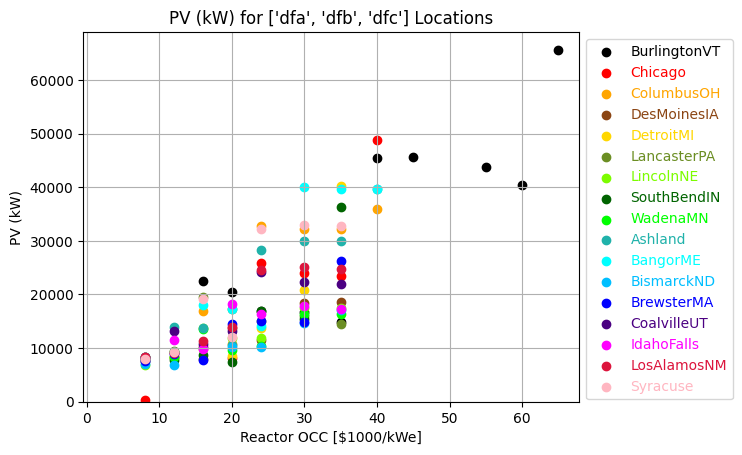

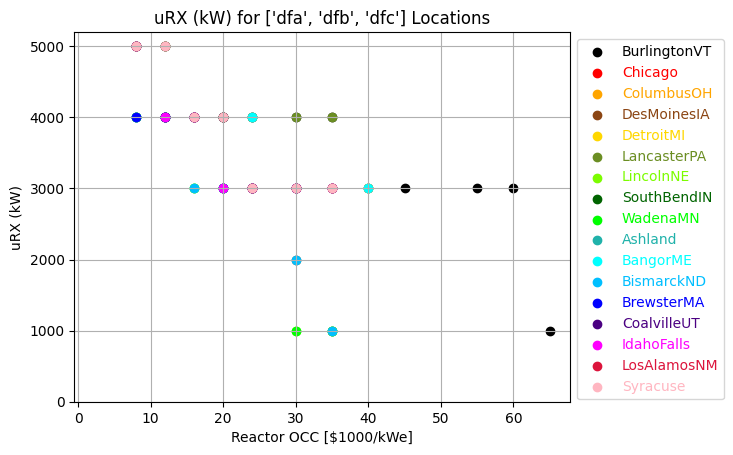

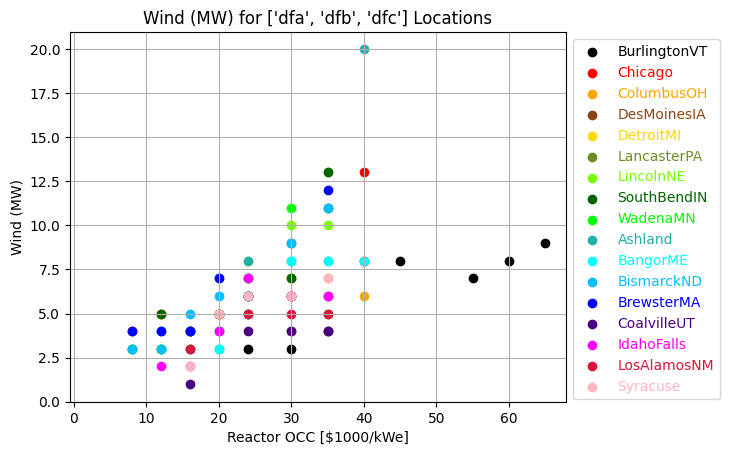

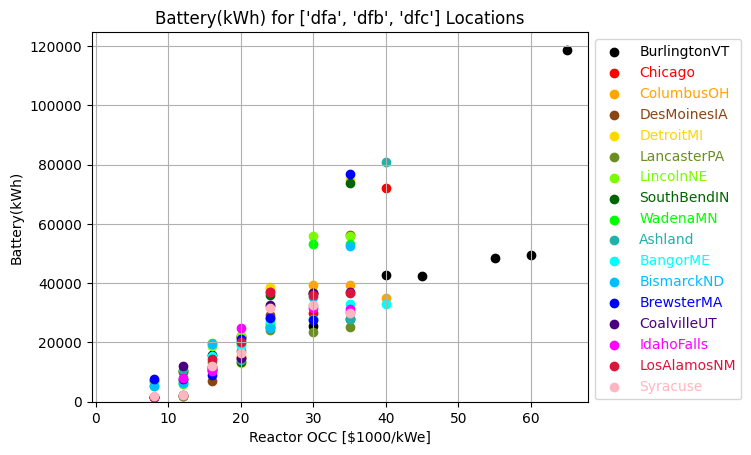

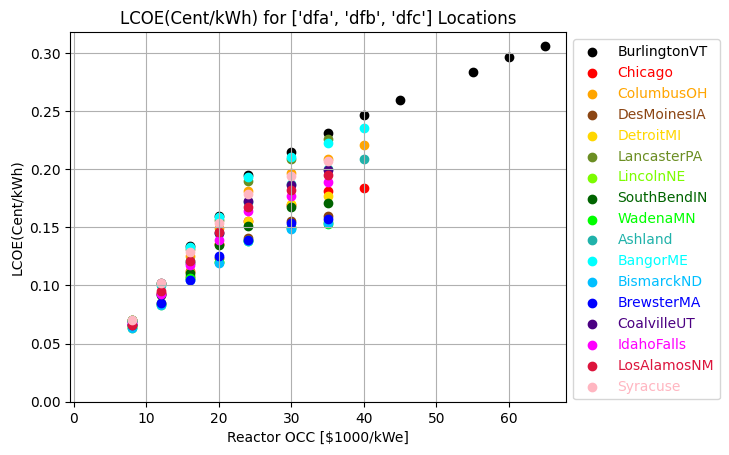

In [147]:
## STACKED BAR CHART TO DEMONSTRATE DATA BEFORE RAINBOW PLOT
koppens_modeled=['bwh', 'csa','csb','dfa','dfb','dfc', 'bsh',  'cfa', 'bsk', 'cfb',  'af', 'dsb', 'am',  'bwk', 'abs']

#KCC = ['cfa',"cfb"]
KCC = [ 'dfa','dfb','dfc']
cases = [ 'Case2' , 'Case25' , 'Case3' , 'Case35' , 'Case4' , 'Case5' ,  'Case6',
         'Case7' , 'Case8' , 'Case10' , 'Case11' , 'Case12' , 'Case13',
        'Case14' , 'Case15',  'Case16'];

loc_var_dict = {}
for kcc in KCC:
    display("KCC==\'"+kcc + "\'") 
    loc_var_dict[kcc] =  opt_out.query("KCC==\'"+kcc + "\'");
    for c in cases:
        try: 
            c = loc_var_dict[kcc].loc[(str(c),slice(None))]
            #display(c)
        except:
            pass
#display(loc_var_dict)


# make as a loop that doesn't break?


colors = ['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
        'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
        'indigo', 'fuchsia','crimson', 'lightpink']
# for k in KCC:
#     demo = [i for i in loc_var_dict[k].loc['Case1'].index]
#     for i in demo: 
#         print(i)
#         ax.scatter(i, Case1.loc[i]['Cost/COE\n($)']*1000,marker='*',s=200,color='blue')
#         m=0;
#         for j in cases:
#             plt_color= colors[m]
#             m=m+1;
#             try:
#                 ax.scatter(i, loc_var_dict[k].loc[j].loc[i]['Cost/COE\n($)']*1000, color=plt_color)
#             except: 
#                 break 
# 
costs = [ 8,12,16,20,24,30,35,40,45,55,60,65,70,80,85,95]


#width = 0.5
#legend_list = []
# for k in KCC:
#     bottom = 0
#     demo = [i for i in loc_var_dict[k].loc['Case1'].index]
#     print(demo)
#     for i in demo: 
#         m=0;
#         print(i)
#         p = ax.bar(i, Case1.loc[i]['Cost/COE\n($)']*1000, width, color='blue',label='OnlyRenewables', bottom=bottom)
#         #if 'Only Renewables' not in legend_list:
#         #    legend_list.append('Only Renewables')
#         bottom += bottom
#         for j in cases:
#             plt_color= colors[m]
#             m=m+1;
#             #print(m)
#             try:
#                 ax.scatter(i, loc_var_dict[k].loc[j].loc[i]['Cost/COE\n($)']*1000, color=plt_color)
#                 #print(j)
#                 if j not in legend_list:
#                     print(j)
#                     legend_list.append(j)
#             except: 
#                 break 




"""
FOR COLORS: APPLY DICTIONARY PAIRING AT START? MAP CITIES -> COLOR, CALL DICT FOR THAT?
"""
city_list = []
for kcc in KCC:
    for j in [i for i in loc_var_dict[kcc].loc['Case1'].index]:
        city_list.append(j)
print(city_list)
city_color = {k:v for (k,v) in zip(city_list, colors)}
print(city_color)



data_strs = ['Architecture/PV\n(kW)','Architecture/GenLarge\n(kW)', 'Architecture/G1500', 'Architecture/1kWh LI','Cost/COE\n($)']  # 'Architecture/PV\n(kW)','Architecture/GenLarge\n(kW)', 'Architecture/G1500', 'Architecture/1kWh LI','Cost/COE\n($)'
plot_str  = ['PV (kW)', 'uRX (kW)', 'Wind (MW)', 'Battery(kWh)', 'LCOE(Cent/kWh)']    # 'PV (kW)', 'uRX (kW)', 'Wind (kW)', 'Wind(kW)', 'LCOE($/MWh)' 
for str in range(len(data_strs)):
    legend_list = []
    plt.figure()
    string = data_strs[str]
    plot = plot_str[str]
    for k in KCC:
        cities = [i for i in loc_var_dict[k].loc['Case2'].index]
        demo = [i for i in costs]
        for i in range(len(demo)):
            cost_prof=cases[i]
            for j in cities:
                if j not in legend_list:
                    try:
                        plt.scatter(costs[i], loc_var_dict[k].loc[cost_prof].loc[j][string], color=city_color[j],label=j)
                        legend_list.append(j)
                    except: 
                        break 
                else:
                    try:
                        #print(type(costs[i]))
                        plt.scatter(costs[i], loc_var_dict[k].loc[cost_prof].loc[j][string], color=city_color[j])
                    except: 
                        break 
    
    plt.ylabel(f'{plot}')
    plt.xlabel('Reactor OCC [$1000/kWe]')
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(left=-0.5)
    plt.legend(labelcolor='linecolor',bbox_to_anchor=(1, 1))
    plt.title(f'{plot} for {KCC} Locations', fontsize='large')
    plt.grid(True)
    plt_name = f'/loc_var_{kcc}_{str}.svg'#f'/loc_var_{KCC}_{plot}.svg'
    plt.savefig(image_dir + plt_name)
    



In [ ]:
#BBox = ((-125.068,   -67.061,      
#         49.383, 24.283))
#ruh_m = plt.imread(os.getcwd() + '/usa_map.png')
#
#fig, ax = plt.subplots(figsize = (24,16))
#ax.scatter(coords_df['Neg. Longitude'] , coords_df['Latitude (decimal degrees)'], zorder=1, alpha= 0.2, c='b', s=10)
#ax.set_title('Plotting Spatial Data on Map of USA')
#ax.set_xlim(BBox[0],BBox[1])
#ax.set_ylim(BBox[2],BBox[3])
#ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

lat = coords_df['Latitude (decimal degrees)']
long = coords_df['Neg. Longitude']
places = coords_df['Name/Nearby Landmark']
kopppens = coords_df['KCC']
for i in Case1.index.array:
    print(i)
    for j in cases:
        print(j)
        print(type(j))
        k=j.loc['Cost/COE\n($)']*1000
        print(i, j,k)
data = {'Location':places, 'KCC':kopppens ,'Latitude':lat, 'Longitude':long}
data_locvar = pd.DataFrame(data)
print(data_locvar)
data_locvar.to_csv('LOCVARDATAFRAME.csv')

In [ ]:
# KCC RAINBOW PLOT
with plt.rc_context():
    plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
                                                    'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
                                                    'indigo', 'fuchsia','crimson', 'lightpink'])
    fig = plt.figure()
    fig, ax=plt.subplots(figsize=(36,12))
    ax.scatter( Case1.index.array, Case1['Cost/COE\n($)']*1000,marker='*',s=200)
    ax.scatter( Case2.index.array, Case2['Cost/COE\n($)']*1000)
    ax.scatter( Case25.index.array,Case25['Cost/COE\n($)']*1000)
    ax.scatter( Case3.index.array, Case3['Cost/COE\n($)']*1000)
    ax.scatter( Case35.index.array,Case35['Cost/COE\n($)']*1000)
    ax.scatter( Case4.index.array, Case4['Cost/COE\n($)']*1000)
    ax.scatter( Case5.index.array, Case5['Cost/COE\n($)']*1000)
    ax.scatter( Case6.index.array, Case6['Cost/COE\n($)']*1000)
    ax.scatter( Case7.index.array, Case7['Cost/COE\n($)']*1000)
    ax.scatter( Case8.index.array, Case8['Cost/COE\n($)']*1000)
    ax.scatter(Case10.index.array,Case10['Cost/COE\n($)']*1000)
    ax.scatter(Case11.index.array,Case11['Cost/COE\n($)']*1000)
    ax.scatter(Case12.index.array,Case12['Cost/COE\n($)']*1000)
    ax.scatter(Case13.index.array,Case13['Cost/COE\n($)']*1000)
    ax.scatter(Case14.index.array,Case14['Cost/COE\n($)']*1000)
    ax.scatter(Case15.index.array,Case15['Cost/COE\n($)']*1000)
    ax.scatter(Case15.index.array,Case15['Cost/COE\n($)']*1000)
    ax.legend(['Only Renewables', '$8,000/kWe','$12,000/kWe', 
               '$16,000/kWe', '$20,000/kWe','$24,000/kWe', '$30,000/kWe','$35,000/kWe','$40,000/kWe',
               '$45,000/kWe','$55,000/kWe','$60,000/kWe','$65,000/kWe','$70,000/kWe','$80,000/kWe',
               '$85,000/kWe','$95,000/kWe'], fontsize='large')
    plt.ylabel('LCOE [$/MWhre]')
    plt.xlabel('Location')
    plt.title('Levelized Cost of Electricity for All Studied Locations w/Assumed MR Capital Cost', fontsize='large')
    plt.xticks(rotation=90);
    ax.grid(True)
plt.savefig(image_dir + '/loc_var_all.svg')

In [ ]:
KCC = ['cfa']
#print(mlr_opt_out)
mlr_dict = {}
cases_mlr = [ 'Case2' , 'Case3' ,'Case4'];
for kop in KCC:
    display("KCC==\'"+kop + "\'") 
    mlr_dict[kop] =  mlr_opt_out.query("KCC==\'"+kop + "\'");
    for c in cases_mlr:
        print(c)
        c = mlr_dict[kop].loc[(str(c),slice(None))]
        i = 0
        locs=[]
        indices=c.index
        for h in range(len(indices)):
            if str(indices[h][0]) not in locs:
                locs.append(indices[h][0])
                i = i+1
            else:
                pass
        print(locs)
    #### ABOVE COLLECTS LOCATIONS AND CASES
    #### BELOW TURNS IT TO LOCATIONS -> CASES
    #### THIS DATA TRANSFORMATION ALLOWS INTEROGATION OF EACH INDIVIDUAL 
        for place in locs:
            index   = c.loc[place].index.array
            nuclear = c.loc[place]['Architecture/GenLarge\n(kW)'][0]
            solar   = c.loc[place]['Architecture/PV\n(kW)'][0]                
            wind    = c.loc[place]['Architecture/G1500'][0]                
            batt    = c.loc[place]['Architecture/1kWh LI'][0]  
            LCOE    = c.loc[place]['Cost/COE\n($)'][0]  
            print(f'LCOE: {LCOE}, Nuclear: {nuclear}')
    


In [ ]:
# DATA FOR MLR
#for index = opt_out.ind 
#display(pd.MultiIndex.get_level_values(opt_out('CaseNum')))
mlr_dict = {}

KCC = koppens_modeled

max_rel_diff = 0;
avg_diff=0
counter=0

max_rel_diff_solar = 0;
avg_diff_solar=0
counter_solar=0

max_rel_diff_wind = 0;
avg_diff_wind=0
counter_wind=0

max_rel_diff_batt = 0;
avg_diff_batt=0
counter_batt=0

max_rel_diff_nuclear = 0;
avg_diff_nuclear=0
counter_nuclear=0



for kcc in KCC:
    display("KCC==\'"+kcc + "\'") 
    mlr_dict[kcc] =  mlr_opt_out.query("KCC==\'"+kcc + "\'");
    for c in cases:
        print(c)
        try: 
            c = mlr_dict[kcc].loc[(str(c),slice(None))]
            print(c)
            i = 0
            locs=[]
            indices=c.index
            for h in range(len(indices)):
                if str(indices[h][0]) not in locs:
                    locs.append(indices[h][0])
                    i = i+1
                else:
                    pass

            for place in locs:
                rel_diff = (c.loc[place]['Cost/COE\n($)'][0] - c.loc[place]['Cost/COE\n($)'][-1])/c.loc[place]['Cost/COE\n($)'][-1]
                rel_diff_solar = abs((c.loc[place]['Architecture/PV\n(kW)'][0] - c.loc[place]['Architecture/PV\n(kW)'][-1])/c.loc[place]['Architecture/PV\n(kW)'][-1])
                rel_diff_wind  = abs((c.loc[place]['Architecture/G1500'][0] - c.loc[place]['Architecture/G1500'][-1])/c.loc[place]['Architecture/G1500'][-1])
                rel_diff_batt  = abs((c.loc[place]['Architecture/1kWh LI'][0] - c.loc[place]['Architecture/1kWh LI'][-1])/c.loc[place]['Architecture/1kWh LI'][-1])
                rel_diff_nuclear  = abs((c.loc[place]['Architecture/GenLarge\n(kW)'][0] - c.loc[place]['Architecture/GenLarge\n(kW)'][-1])/c.loc[place]['Architecture/GenLarge\n(kW)'][-1])
                # print(place)
                #print(rel_diff_batt*100, '%')
                if max_rel_diff < rel_diff:
                    max_rel_diff = rel_diff
                    avg_diff = avg_diff + rel_diff
                    counter=counter+1
                if max_rel_diff_solar < rel_diff_solar:
                    max_rel_diff_solar = rel_diff_solar
                    avg_diff_solar = avg_diff_solar + rel_diff_solar
                    counter_solar=counter_solar+1
                if max_rel_diff_wind < rel_diff_wind:
                    max_rel_diff_wind = rel_diff_wind
                    avg_diff_wind = avg_diff_wind + rel_diff_wind
                    counter_wind=counter_wind+1
                if max_rel_diff_batt < rel_diff_batt:
                    max_rel_diff_batt = rel_diff_batt
                    avg_diff_batt = avg_diff_batt + rel_diff_batt
                    counter_batt=counter_batt+1
                if max_rel_diff_nuclear < rel_diff_nuclear:
                    max_rel_diff_nuclear = rel_diff_nuclear
                    avg_diff_nuclear = avg_diff_nuclear + rel_diff_nuclear
                    counter_nuclear=counter_nuclear+1
            print('loop working properly')
        except:
            pass
print('The average relative difference between MLR is :', str(100*(avg_diff/counter)), '%.')
print('The maximum relative difference between MLR extremes is : ',str(max_rel_diff*100), ' %.')   
print('The average relative difference between solar capacity in MLRs is :',            str(100*(avg_diff_solar/counter_solar)), '%.')
print('The maximum relative difference between solar capacity in MLRs extremes is : ',  str(100*max_rel_diff_solar), ' %.')  
print('The average relative difference between wind capacity in MLRs is :',             str(100*(avg_diff_wind/counter_wind)), '%.')
print('The maximum relative difference between wind capacity in MLRs extremes is : ',   str(100*max_rel_diff_wind), ' %.') 
print('The average relative difference between battery capacity in MLRs is :',          str(100*(avg_diff_batt/counter_batt)), '%.')
print('The maximum relative difference between battery capacity in MLRs extremes is : ',str(100*max_rel_diff_batt), ' %.') 
print('The average relative difference between nuclear capacity in MLRs is :',          str(100*(avg_diff_nuclear/counter_nuclear)), '%.')
print('The maximum relative difference between nuclear capacity in MLRs extremes is : ',str(100*max_rel_diff_nuclear), ' %.') 

testcase='Ashland'
quantity='Cost/COE\n($)'
Case2= mlr_opt_out.loc[("Case2",slice(None))]
Case3= mlr_opt_out.loc[("Case3",slice(None))]
Case4= mlr_opt_out.loc[("Case4",slice(None))]
Case2test = Case2.loc[(testcase,slice(None))]
Case3test = Case3.loc[(testcase,slice(None))]
Case4test = Case4.loc[(testcase,slice(None))]
fig = plt.figure()
fig, ax=plt.subplots(figsize=(8,4))
# 'Architecture/GenLarge\n(kW)'
ax.scatter( Case2test.index.array, Case2test[quantity],marker='*',s=200)
ax.scatter( Case3test.index.array, Case3test[quantity],marker='*',s=200)
ax.scatter( Case4test.index.array, Case4test[quantity],marker='*',s=200)
ax.legend(['$8,000/kWe','$16,000/kWe','$24,000/kWe'], fontsize='large')
plt.ylabel(quantity)
plt.xlabel('minimum load ratio [%]')
plt.title(f'Levelized Cost of Electricity for {testcase} w/ various Assumed MR Capital Cost', fontsize='large')
plt.xticks(rotation=90);
ax.grid(True)

plt.savefig(image_dir + '/mlr_pv.svg')

In [ ]:
# DATA FOR util
low = util_opt_out.loc[("1.3MWe",slice(None))]
high = util_opt_out.loc[("2.6MWe",slice(None))]
display(low)
display(high)

In [ ]:
## Comparing high utility throughput to low utility throughput 
utility_price = ['6', 12, 18, 24, 30]
utility_dict = {}
str_names = []
for i in utility_price:
    low_strname = str(f"low_"+str(i)) #collects 1.3MWe utility case
    if low_strname not in str_names:
        str_names.append(low_strname)
    high_strname = str(f"high_"+str(i)) #collect 2.6 MWe utility case
    if high_strname not in str_names:
        print('appended')
        str_names.append(high_strname)
    utility_dict[low_strname] = low.query(f"Price=='{i}'")
    utility_dict[high_strname] = high.query(f"Price=='{i}'")


fig = plt.figure()
fig, ax =plt.subplots(figsize=(12,6))
koppen = ['cfa','cfb']
legend_list = []
for j in koppen:
    for i in str_names:
        if i not in legend_list:
            if 'high' in i:
                legend_list.append(str(i.replace('high_','2.6MWe Connection_')))
                plt.scatter( utility_dict[f'{str(i)}'].query(f"KCC== '{j}'").droplevel(['Price','KCC']).index,   utility_dict[f'{str(i)}'].query(f"KCC== '{j}'")['Cost/COE\n($)']*1000,marker='>',s=100)
            if 'low' in i:
                legend_list.append(str(i.replace('low_','1.3MWe Connection_')))
                plt.scatter( utility_dict[f'{str(i)}'].query(f"KCC== '{j}'").droplevel(['Price','KCC']).index,   utility_dict[f'{str(i)}'].query(f"KCC== '{j}'")['Cost/COE\n($)']*1000,marker='<',s=100)




plt.ylabel('LCOE for 1.3MWe utility connection')
plt.xticks(rotation=90);
# 
# plt.scatter( Case1CFA.index.array, Case1CFA['Cost/COE\n($)']*1000,marker='>',s=200)
# ax4.scatter( Case1CFA.index.array, Case3CFA['Cost/COE\n($)'])
# ax4.scatter( Case1CFA.index.array, Case4CFA['Cost/COE\n($)'])
# plt.xticks(rotation=90);

plt.legend(legend_list)
#             '1.3MWe Connection @240 $/MWh',
#             '1.3MWe Connection @180 $/MWh',
#             '1.3MWe Connection @120 $/MWh',
#             '1.3MWe Connection @ 60 $/MWh',
#             'Only Renewables'])
#ax3.legend(['Only Renewables'])
# ax4.legend(['$16,000/MWe Nuclear', '$24,000/MWe Nuclear'])

plt.ylabel('LCOE [$/MWhre]')
plt.title('Levelized Cost of Electricity for Cf Locations under various assumptions', fontsize='large')

plt.xticks(rotation=90);
plt.grid(True);

# high_30.plot(y='Cost/COE\n($)', use_index=True)
# plt.xticks(rotation=90);
# plt.ylim([0.10  ,0.3])
plt.savefig(image_dir + '/util_contin.svg')

In [ ]:
m = len(Case2CFA)
fig = plt.figure(figsize=(24,12))
barWidth = 0.25
# Grabbing Generator Size Data
bars1 = Case2CFA["Architecture/GenLarge\n(kW)"]
#bars15 = Case25CFA["Architecture/GenLarge\n(kW)"]
bars2 = Case3CFA["Architecture/GenLarge\n(kW)"]
#bars25 = Case35CFA["Architecture/GenLarge\n(kW)"]
bars3 = Case4CFA["Architecture/GenLarge\n(kW)"]
#ranges
r1 = np.arange(m)
#r15 = [x+barWidth for x in r1]
r2 = [x+barWidth for x in r1]
#r25 = [x+barWidth for x in r2]
r3 = [x+barWidth for x in r2]

# Plotting
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='LowCostNuclear')
#plt.bar(r15, bars15, width=barWidth, edgecolor='white', label='LoMidCostNuclear')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='MidCostNuclear')
#plt.bar(r25, bars25, width=barWidth, edgecolor='white', label='MidCostNuclear')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='HighCostNuclear')
# Add xticks on the middle of the group bars
plt.ylabel('Installed Nuclear Capacity [MWe]',fontweight='bold')
plt.xlabel('[Cfa] Humid Subtropical Locations',fontweight='bold')
plt.title('Predicted Installed Nuclear Capacity for Modeled Cfa Locations',fontweight='bold')
plt.xticks([r + barWidth for r in range(m)], Case2CFA.index.values)
plt.xticks(rotation=90);
plt.grid(True)
 


In [ ]:
# Initial KCC Plots
with plt.rc_context():
    plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'orange', 'saddlebrown', 'gold','olivedrab','lawngreen',
                                                    'darkgreen','lime','lightseagreen','cyan','deepskyblue','blue',
                                                    'indigo', 'fuchsia','crimson'])
    fig = plt.figure()
    fig, ax=plt.subplots(figsize=(12,6))
    #ax.scatter( Case1CFA.index.array, Case1CFA['Architecture/GenLarge\n(kW)']*1000,marker='*',s=200)
    ax.bar( Case2CFA.index.array, Case2CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.bar( Case3CFA.index.array, Case3CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.bar( Case4CFA.index.array, Case4CFA['Architecture/GenLarge\n(kW)']/1000)
    ax.legend([ 'LowCostNuclear', 'MidCostNuclear', 'HighCostNuclear'], fontsize='large')
    plt.ylabel('Installed Nuclear Capacity [MWe]')
    plt.xlabel('[Cfa] Humid Subtropical Locations')
    plt.xticks(rotation=90);
    #plt.yticks([3,4,5])
    ax.grid(True)
    plt.savefig(image_dir + '/kcc_cfa_comp.svg')